#Import dependencies#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from itertools import chain, combinations
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, LeaveOneOut, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

#Function definitions#

In [ ]:
# Subset generation

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))

In [ ]:
# Top 5 model Selection by feature fubsets

def top5_model_selector(param_class_num):
  """
  Performs a best subset selection for the provided parameter class (param_class_num)
  and returns top 5 models.
  """



  features = list(range(X_train_2.shape[1]))
  subset_features2 = [subset for subset in all_subsets(features) if len(subset) == param_class_num]

  models_performance = [] # List for models' performance report
  column_names = X_train_2.columns

  for subset in subset_features2:
      if subset:  # Avoid empty set
          # Convert indices to actual column names
          subset_names = [column_names[i] for i in subset]

          param_class = f'M{param_class_num}'

          # Select the subset of features for X
          X_train_subset = X_train_2[subset_names]
          X_test_subset = X_test_2[subset_names]

          # Model creation and data fitting (train)
          model = LinearRegression()
          model.fit(X_train_subset, y_train)

          # Prediction for train and test samples
          pred_train = model.predict(X_train_subset)
          pred_test = model.predict(X_test_subset)

          # Metrics calculation for train and test samples
          mae_train = mean_absolute_error(y_train, pred_train)
          rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
          r2_train = r2_score(y_train, pred_train)

          mae_test = mean_absolute_error(y_test, pred_test)
          rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
          r2_test = r2_score(y_test, pred_test)

          # Leave-one-out (LOO) cross-validation on train sample
          y_train_loo = cross_val_predict(model, X_train_2.iloc[:, list(subset)], y_train, cv=loo)
          mae_train_loo = mean_absolute_error(y_train, y_train_loo)

          # Updating list for models' performance report
          models_performance.append((mae_train, rmse_train, r2_train, mae_test, rmse_test, r2_test, mae_train_loo, model, subset, subset_names, param_class))





  # Models sorting based on a training metrics
  top5_models = sorted(models_performance, key=lambda x: x[0])[:5]


  # Printing performance report for top 5 models
  for i, (mae_train, rmse_train, r2_train, mae_test, rmse_test, r2_test, mae_train_loo, model, subset, subset_names, param_class) in enumerate(top5_models, 1):
      print(f"Parameter class: {param_class}") # Parameter class signifies the number of contributing features in the model (M1-M6).
      print(f"Model {i}:") # Model number in a parameter class (1-5)
      print(f"Train MAE: {mae_train}, Train RMSE: {rmse_train}, Train R2: {r2_train}")
      print(f"Test MAE: {mae_test}, Test RMSE: {rmse_test}, Test R2: {r2_test}")
      print(f"Train LOO MAE: {mae_train_loo}")
      print(f"Features_indices: {subset}, Features_names: {', '.join(subset_names)}") # Index value and name of contributing features in the model
      print(f"Coefficients: {model.coef_}") # Correspoding coefficients of contributing features in the model
      print(f"Intercept: {model.intercept_}" + '\n') # Intercept of the model


  return top5_models



In [ ]:
# Model performance visualization

def plot_actual_vs_predicted(model, feature_indices, model_subset_names, param_class_num, y_train_loo=None, margin_ledgends=None):
    """
    Plots measured vs. predicted values for train, and test samples (LOO - optional),
    displays performance metrices (MAE, RMSE, R2 score),
    and plots the coefficients of the contributing features for a given model.
    """

    print(f'For best model in M{param_class_num} parameter class:')

    # Prepare data subsets
    if isinstance(feature_indices, int):
        feature_indices = [feature_indices]
    elif isinstance(feature_indices, tuple):
        feature_indices = list(feature_indices)

    X_test_subset = X_test_2.iloc[:, feature_indices]
    X_train_subset = X_train_2.iloc[:, feature_indices]

    # Prediction for train and test samples
    y_pred_test = model.predict(X_test_subset)
    y_pred_train = model.predict(X_train_subset)

    # LOO CV: optional
    if y_train_loo is not None:
      mae_loo = mean_absolute_error(y_train, y_train_loo)
    else:
      mae_loo = None


    # Metrics calculation for train and test samples
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Plotting
    plt.figure(figsize=(10, 10))
    sns.set_style("darkgrid")

    # Setting x and y limits
    plot_scale_start = -3.0
    plot_scale_end = 0.6
    plot_least_count = 0.5
    plt.xlim(plot_scale_start, plot_scale_end)
    plt.ylim(plot_scale_start, plot_scale_end)

    # Creating vectors X and Y
    x_ideal = np.linspace(plot_scale_start, plot_scale_end, 2)
    dev_line_color='grey'

    # Lines for error margins
    plt.plot(x_ideal, x_ideal - 0.50, linestyle=':', color=dev_line_color, zorder=1)
    plt.plot(x_ideal, x_ideal - 0.25, linestyle='--', color=dev_line_color, zorder=1)
    plt.plot(x_ideal, x_ideal + 0.00, linestyle='-', color=dev_line_color, zorder=1)
    plt.plot(x_ideal, x_ideal + 0.25, linestyle='--', color=dev_line_color, zorder=1)
    plt.plot(x_ideal, x_ideal + 0.50, linestyle=':', color=dev_line_color, zorder=1)


    # Train sample plot
    plt.scatter(y_train, y_pred_train, s=200, facecolors='#91BAD6', edgecolors='#003d7a', linewidth=2, label='Train', alpha=1, zorder=3)

    # Test sample plot
    plt.scatter(y_test, y_pred_test, s=150, marker='s', facecolors='#FBD9D3', edgecolors='#8B0000', linewidth=2, label='Test', alpha=1, zorder=3)

    # LOO results (optional)
    if y_train_loo is not None:
        plt.scatter(y_train, y_train_loo, s=200, facecolors='none', edgecolors='#003d7a', linewidth=2, label='LOO', zorder=2)


    coef_rounded = [round(c, 2) for c in model.coef_] # Rounding off to two decimal places
    merged_coef_names = " + ".join(f"({c} * {n})" if c > 0 else f"- ({-c} * {n})" for c, n in zip(coef_rounded, model_subset_names))
    # Adjusting the string for the negative sign
    merged_coef_names_formatted = merged_coef_names.replace(" + -", " - ")

    model_p1 = round(model.intercept_, 2) # Intercept c
    model_p2 = merged_coef_names_formatted # Compiled mx
    # Merging the both components of the linear equation (y = mx + c)
    model_present = f"({model_p1}) + {model_p2}"

    # Labels settings
    plt.title(r"$ΔΔG^{‡}$ = " + f"{model_present}", fontsize=15,x=0.00, y=1.05, loc='left') # For printing the complete equation above the plot
    plt.xlabel(r'Measured $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=20, labelpad=15)
    plt.ylabel(r'Predicted $ΔΔG^{‡}$ (kcal mol$^{-1}$)', fontsize=20, labelpad=15)

    # Setting x and y ticks
    plt.xticks(np.arange(plot_scale_start, plot_scale_end, plot_least_count), fontsize=18)
    plt.yticks(np.arange(plot_scale_start, plot_scale_end, plot_least_count), fontsize=18)

    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Ledgends settings
    plt.legend(facecolor="white", fontsize=18, loc='upper left')
    plt.grid(True)


    # Reference coordinates for locating metrics inside the plot
    m_x1, m_y1 = 0.02, 0.83 # For R2 scores
    m_x2, m_y2 = 0.23, 1.10 # For MAE values

    # Printing R2 scores
    plt.text(m_x1, m_y1-0.05, f'R$^2$$_{{\mathrm{{train}}}}$ = {r2_train:.2f}', fontsize=18, transform=plt.gca().transAxes)
    plt.text(m_x1, m_y1-0.10, f'R$^2$$_{{\mathrm{{test}}}}$ = {r2_test:.2f}', fontsize=18, transform=plt.gca().transAxes)
    # Printing MAE values
    plt.text(m_x2, m_y2-0.15, f'MAE$_{{\mathrm{{train}}}}$ = {mae_train:.2f}', fontsize=18, transform=plt.gca().transAxes)
    plt.text(m_x2, m_y2-0.20, f'MAE$_{{\mathrm{{test}}}}$ = {mae_test:.2f}', fontsize=18, transform=plt.gca().transAxes)
    if mae_loo is not None:  # Display LOO MAE if available
      plt.text(m_x2, m_y2-0.25, f'MAE$_{{\mathrm{{LOO}}}}$ = {mae_loo:.2f}', fontsize=18, transform=plt.gca().transAxes)


    # Create inset axes (subplot) within the current figure for feature-wise contributions
    ax_inset = inset_axes(plt.gca(), width=3.0, height=0.2*param_class_num, loc='lower right', borderpad=3)
    ax_inset.set_facecolor((1,1,1,0.75))
    ax_inset.grid(False)

    # Bar plot customization
    for idx, val in enumerate(coef_rounded):
        ax_inset.barh(idx, val, color='#003d7a', align='center', edgecolor='none', alpha=1)

    # Set y-axis labels to feature names
    ax_inset.set_yticks(range(len(coef_rounded)))
    ax_inset.set_yticklabels(model_subset_names, fontsize=12)
    ax_inset.tick_params(axis='both', labelsize=12)

    # Optional: set title for the subplot
    ax_inset.set_title(f'feature contributions', fontsize=12)

    # Display ledgends for error margin lines (optional)
    if margin_ledgends is not None:
          legend_lines = [
          mlines.Line2D([], [], color=dev_line_color, linestyle='-', linewidth=1.5, label='   0.00 kcal mol$^{-1}$'),
          mlines.Line2D([], [], color=dev_line_color, linestyle='--', linewidth=1.5, label='± 0.25 kcal mol$^{-1}$'),
          mlines.Line2D([], [], color=dev_line_color, linestyle=':', linewidth=1.5, label='± 0.50 kcal mol$^{-1}$')]
          # Placing the custom legend outside the plot area
          plt.legend(handles=legend_lines, loc='lower right', bbox_to_anchor=(2.14, -0.60), fontsize=15, edgecolor='w')

    # plt.show()
    return plt


#Read data#

In [ ]:
df=pd.read_csv("complete_acac_lig_dataset.csv")

In [ ]:
df

ligand_entry                                          SMILES_FL  \
0         lig_1                O/C(C)=C\C1=N[C@@H](C2=CC=CC=C2)CO1   
1         lig_3               O/C(CC)=C\C1=N[C@@H](C2=CC=CC=C2)CO1   
2         lig_4         O/C(C(C)(C)C)=C\C1=N[C@@H](C2=CC=CC=C2)CO1   
3         lig_5      O/C(C1=CC=CC=C1)=C\C2=N[C@@H](C3=CC=CC=C3)CO2   
4         lig_6  OC(/C=C/C1=CC=CC=C1)=C\C2=N[C@@H](C3=CC=CC=C3)CO2   
5         lig_7         O/C(C(F)(F)F)=C\C1=N[C@@H](C2=CC=CC=C2)CO1   
6         lig_8             O/C(C)=C(C)\C1=N[C@@H](C2=CC=CC=C2)CO1   
7         lig_9          O/C(C)=C\C1=N[C@@H](C2=CC=CC=C2)C(C)(C)O1   
8        lig_10                     O/C(C)=C\C1=N[C@@H](CC(C)C)CO1   
9        lig_11               O/C(C)=C\C1=N[C@@H](CC2=CC=CC=C2)CO1   
10       lig_12                      O/C(C)=C\C1=N[C@@H](C(C)C)CO1   
11       lig_13                          O/C(C)=C\C1=N[C@@H](C)CO1   
12       lig_14                         O/C(C)=C\C1=N[C@@H](CC)CO1   
13       lig_15           O/C(CC1=CC=CC=C1)=N\C2=N[C@@H](C(C)C)CO2   
14       lig_16                      O/C(C)=N\C1=N[C@@H](C(C)C)CO1   
15       lig_17               O/C(C(C)(C)C)=N\C1=N[C@@H](C(C)C)CO1   
16       lig_18      O/C(C1=CC=C(C)C(C)=C1)=N\C2=N[C@@H](C(C)C)CO2   
17       lig_19        O/C(C1=CC=C(OC)C=C1)=N\C2=N[C@@H](C(C)C)CO2   
18       lig_20  O/C(C1=CC(OC)=C(OC)C(OC)=C1)=N\C2=N[C@@H](C(C)...   
19       lig_21  O/C(C1=CC(OC)=C(OC)C(OC)=C1)=N\C2=N[C@@H](C3=C...   
20       lig_22  O/C(C1=CC=C([N+]([O-])=O)C=C1)=N\C2=N[C@@H](C3...   
21       lig_24         O/C(C(C)(C)C)=N\C1=N[C@@H](C2=CC=CC=C2)CO1   

   ligand_type  exp_yield  exp_ee  exp_deldelG  nbo_O1_CMC  nbo_C2_CMC  \
0         enol         72      69    -1.004699    -0.59235     0.48012   
1         enol         79      50    -0.650844    -0.58910     0.48756   
2         enol         59     -16     0.191219    -0.60754     0.50771   
3         enol         57      45    -0.574296    -0.59158     0.45563   
4         enol         66      52    -0.682875    -0.58079     0.42492   
5         enol         16      74    -1.126174    -0.56875     0.36613   
6         enol         73      50    -0.650844    -0.57968     0.49095   
7         enol         80      20    -0.240207    -0.59288     0.47908   
8         enol         64      90    -1.744356    -0.59854     0.48074   
9         enol         22      76    -1.180364    -0.58991     0.47653   
10        enol         45      95    -2.170382    -0.59711     0.48010   
11        enol         52      86    -1.532417    -0.58884     0.47441   
12        enol         53      90    -1.744356    -0.59763     0.47906   
13       amide         16      70    -1.027619    -0.58583     0.67343   
14       amide         20      84    -1.446905    -0.59491     0.65986   
15       amide         15      46    -0.589238    -0.59534     0.69386   
16       amide         25      71    -1.051178    -0.58980     0.64215   
17       amide         18      69    -1.004699    -0.59256     0.64170   
18       amide         20      74    -1.126174    -0.59175     0.64284   
19       amide         15       7    -0.083075    -0.58506     0.64079   
20       amide         10      34    -0.419546    -0.58296     0.63005   
21       amide         19     -14     0.166975    -0.59766     0.68787   

    nbo_X3_CMC  nbo_C4_CMC  ...  nbo_C6_FL  nbo_C7_FL  nbo_O8_FL  \
0     -0.48775     0.57984  ...   -0.10329   -0.08171   -0.47046   
1     -0.49711     0.58141  ...   -0.10356   -0.08367   -0.46996   
2     -0.49581     0.58397  ...   -0.10333   -0.08327   -0.47101   
3     -0.46563     0.57668  ...   -0.10286   -0.08133   -0.46983   
4     -0.46589     0.57302  ...   -0.10380   -0.08142   -0.46985   
5     -0.45396     0.57815  ...   -0.10482   -0.08587   -0.46226   
6     -0.29482     0.59248  ...   -0.10280   -0.08064   -0.48120   
7     -0.48606     0.58691  ...   -0.09826    0.25604   -0.49116   
8     -0.46896     0.58227  ...   -0.08658   -0.09260   -0.47315   
9     -0.

In [ ]:
# Selecting non-features
non_features = ['ligand_entry', 'SMILES_FL', 'ligand_type', 'exp_yield', 'exp_ee', 'exp_deldelG']

X = df.drop(columns = non_features) # Storing features
y = df['exp_deldelG'] # Storing label

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert to a DataFrame
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)

#Feature: Box-plot analysis#

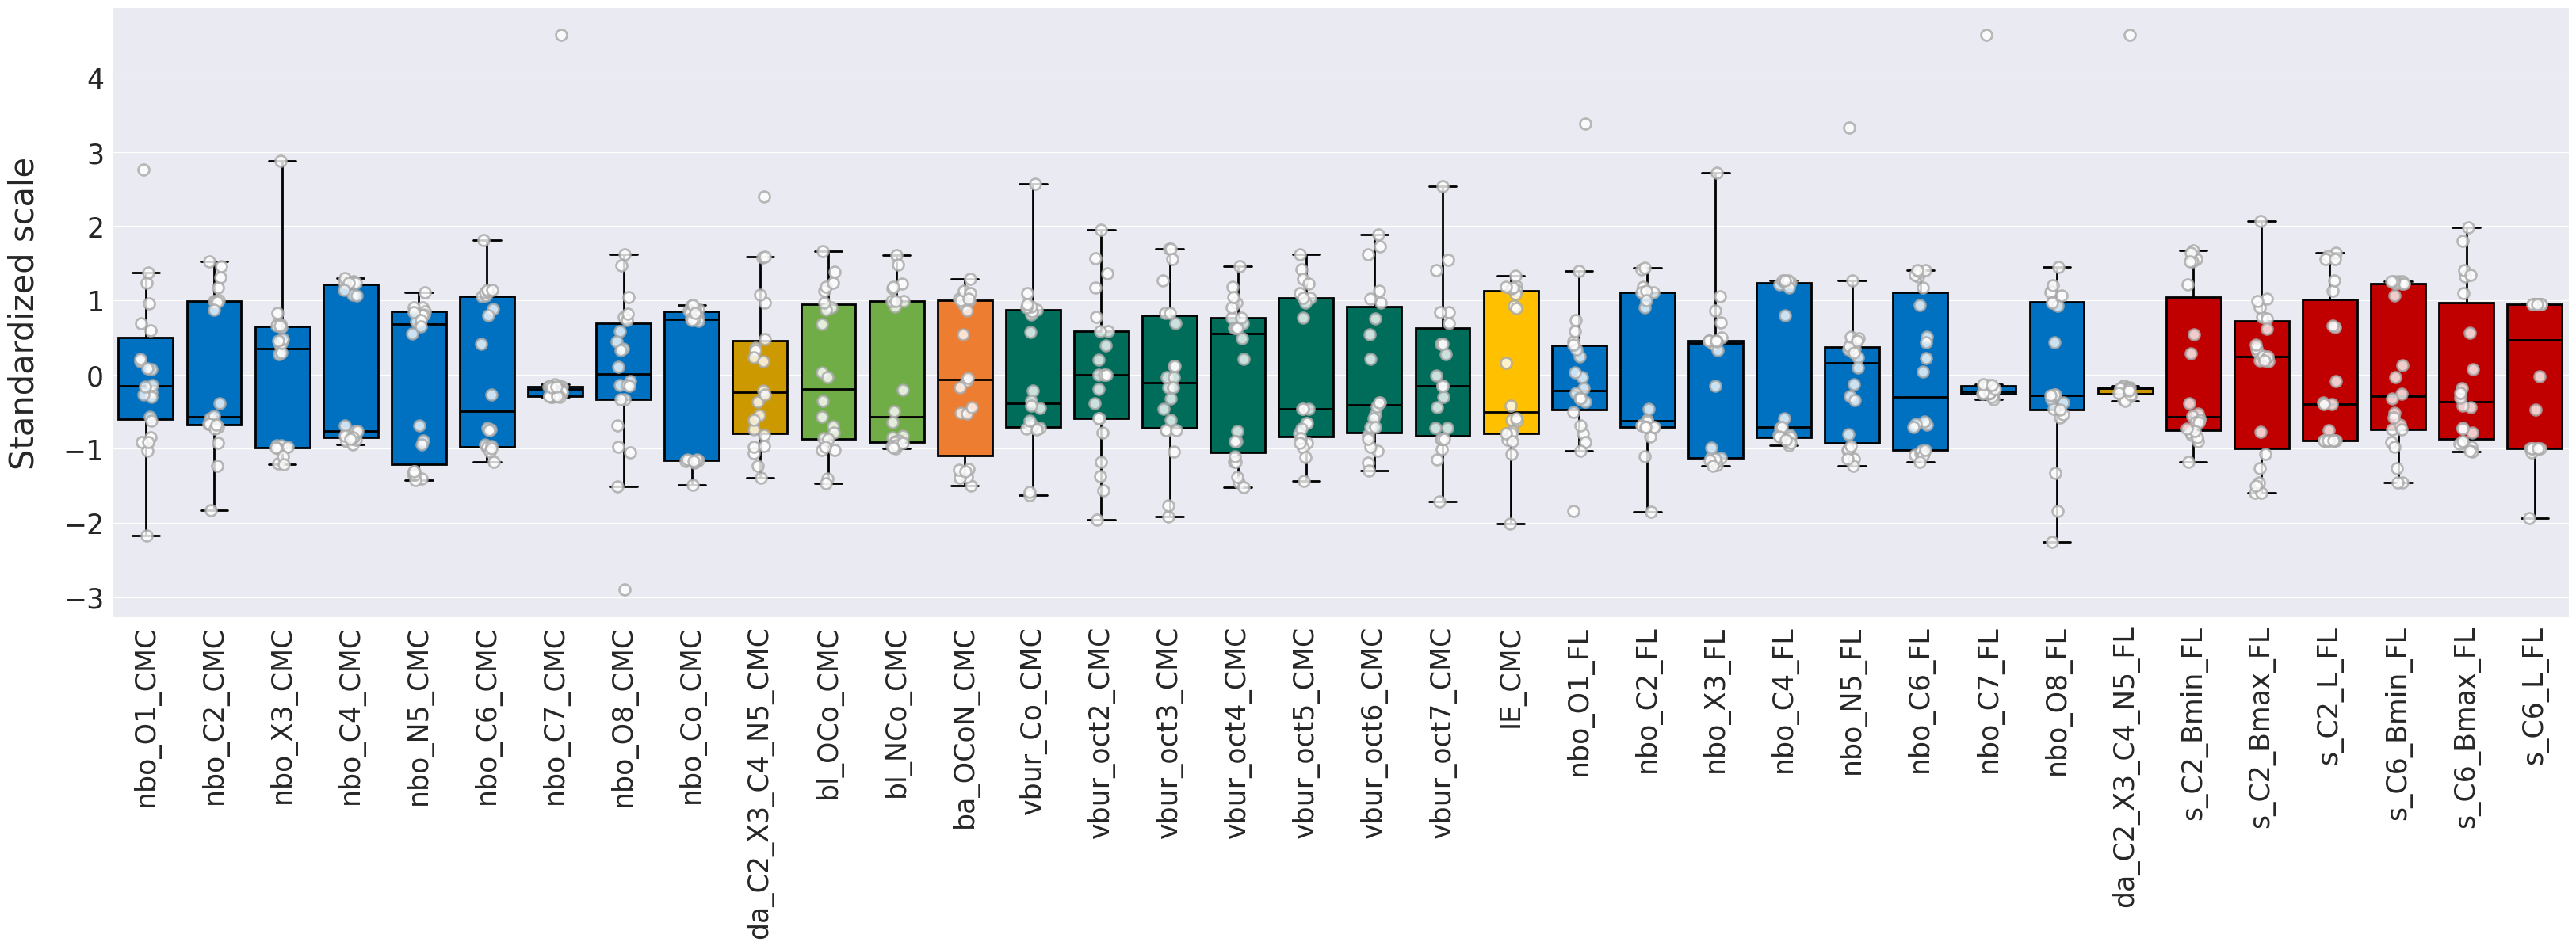

In [ ]:
sns.set_style("darkgrid")

# Define colors for feature categories
color_nbo = "#0070C0" # For NBOs from FL and CMC
color_da = "#CC9900" # For dihedral angles from FL and CMC
color_bl = "#70AD47" # For bond lengths from FL and CMC
color_ba = "#ED7D31" # For bite angle from CMC
color_vbur = "#006D5B" # For burried volumes from CMC
color_energy = "#FFC000" # For interaction energy from CMC
color_sterimol = "#C00000" # For sterimols from FL

default_color = "white"  # Default color
box_outline = 'k'
box_point = 'grey'

plt.figure(figsize=(40, 10))

# Plot stripplot
sns.stripplot(data=X_standardized_df, jitter=True, linewidth=2, size=10, alpha=0.8, color="white", edgecolor="darkgrey")

# Plot boxplot for each feature with different fill colors based on above feature categories
for column in X_standardized_df.columns:
    if column.startswith("nbo_"):
        box_color = color_nbo
    elif column.startswith("da_"):
        box_color = color_da
    elif column.startswith("bl_"):
        box_color = color_bl
    elif column.startswith("ba_"):
        box_color = color_ba
    elif column.startswith("vbur_"):
        box_color = color_vbur
    elif column.startswith("IE_"):
        box_color = color_energy
    elif column.startswith("s_"):
        box_color = color_sterimol
    else:
        box_color = default_color

    sns.boxplot(data=X_standardized_df[[column]], color=box_color,
                boxprops=dict(facecolor=box_color, edgecolor=box_outline),
                whiskerprops=dict(color=box_outline),
                capprops=dict(color=box_outline),
                medianprops=dict(color=box_outline),
                linewidth=2,
                showfliers=False)  # Optionally hide outliers to focus on the distribution of inlier points

plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Standardized scale', fontsize=30, labelpad=20)
plt.show()

#Feature: Correlation analysis#

In [ ]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_standardized_df, y, random_state=0, train_size = 0.8)

In [ ]:
# Correlation for train sample
cor = X_train.corr()

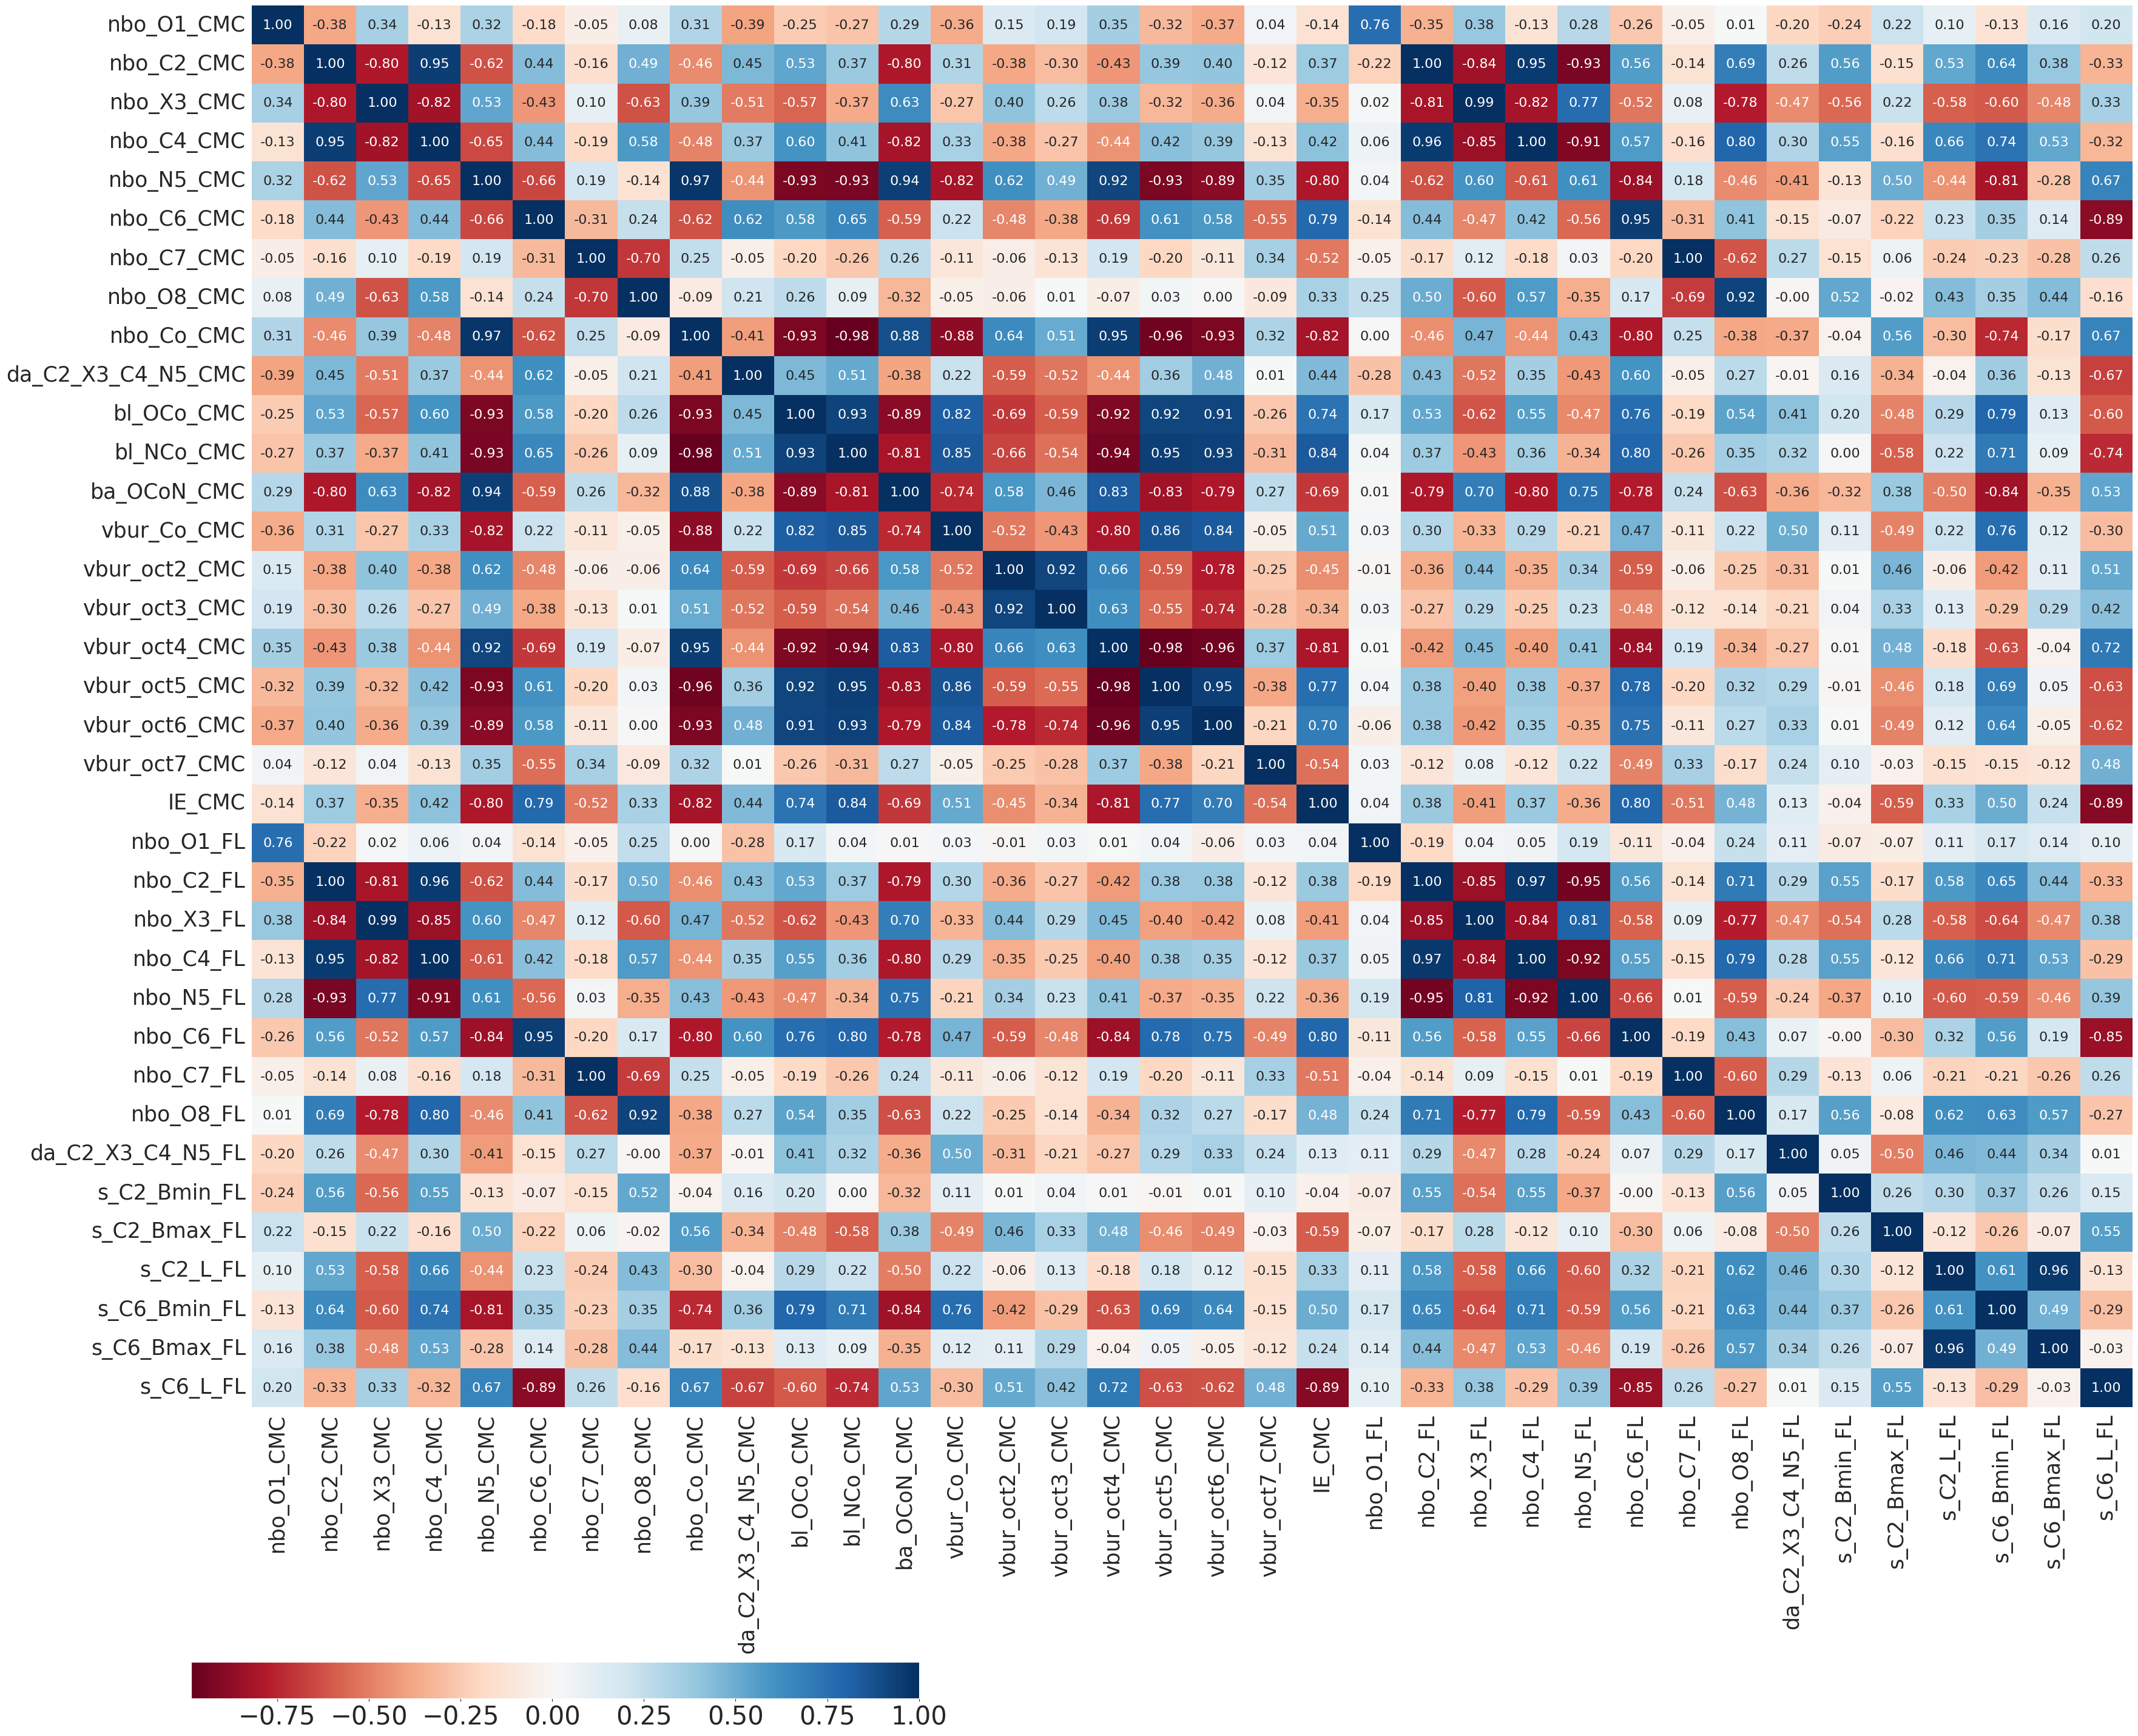

In [ ]:
fig, ax = plt.subplots(figsize=(40, 30))
axs = sns.heatmap(cor, xticklabels=True, yticklabels=True, annot=True,
                  fmt=".2f", cmap="RdBu", annot_kws={'size': 16}, cbar=False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

cbar_ax = fig.add_axes([0.1, -0.05, 0.3, 0.02])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=30)

In [ ]:
# Setting correlation threshold value
threshold = 0.9

# Setting conditional mask to filter out correlations (cor) above the threshold
mask = np.abs(cor) > threshold

columns = np.full((mask.shape[0],), True, dtype = bool)

# Loop for conditional cor check and drop coloumn greater than the threshold
for i in range(mask.shape[0]):
    for j in range(i+1, mask.shape[0]):
        if mask.iloc[i,j]:
            if columns[j]:
                columns[j] = False

# Selecting the columns with cor below the threshold
selected_columns = X_train.columns[columns]
df_features = X_train[selected_columns]

In [ ]:
# Display the features with cor below the threshold
df_features.columns.tolist()

['nbo_O1_CMC',
 'nbo_C2_CMC',
 'nbo_X3_CMC',
 'nbo_N5_CMC',
 'nbo_C6_CMC',
 'nbo_C7_CMC',
 'nbo_O8_CMC',
 'da_C2_X3_C4_N5_CMC',
 'vbur_Co_CMC',
 'vbur_oct2_CMC',
 'vbur_oct7_CMC',
 'IE_CMC',
 'nbo_O1_FL',
 'da_C2_X3_C4_N5_FL',
 's_C2_Bmin_FL',
 's_C2_Bmax_FL',
 's_C2_L_FL',
 's_C6_Bmin_FL',
 's_C6_L_FL']

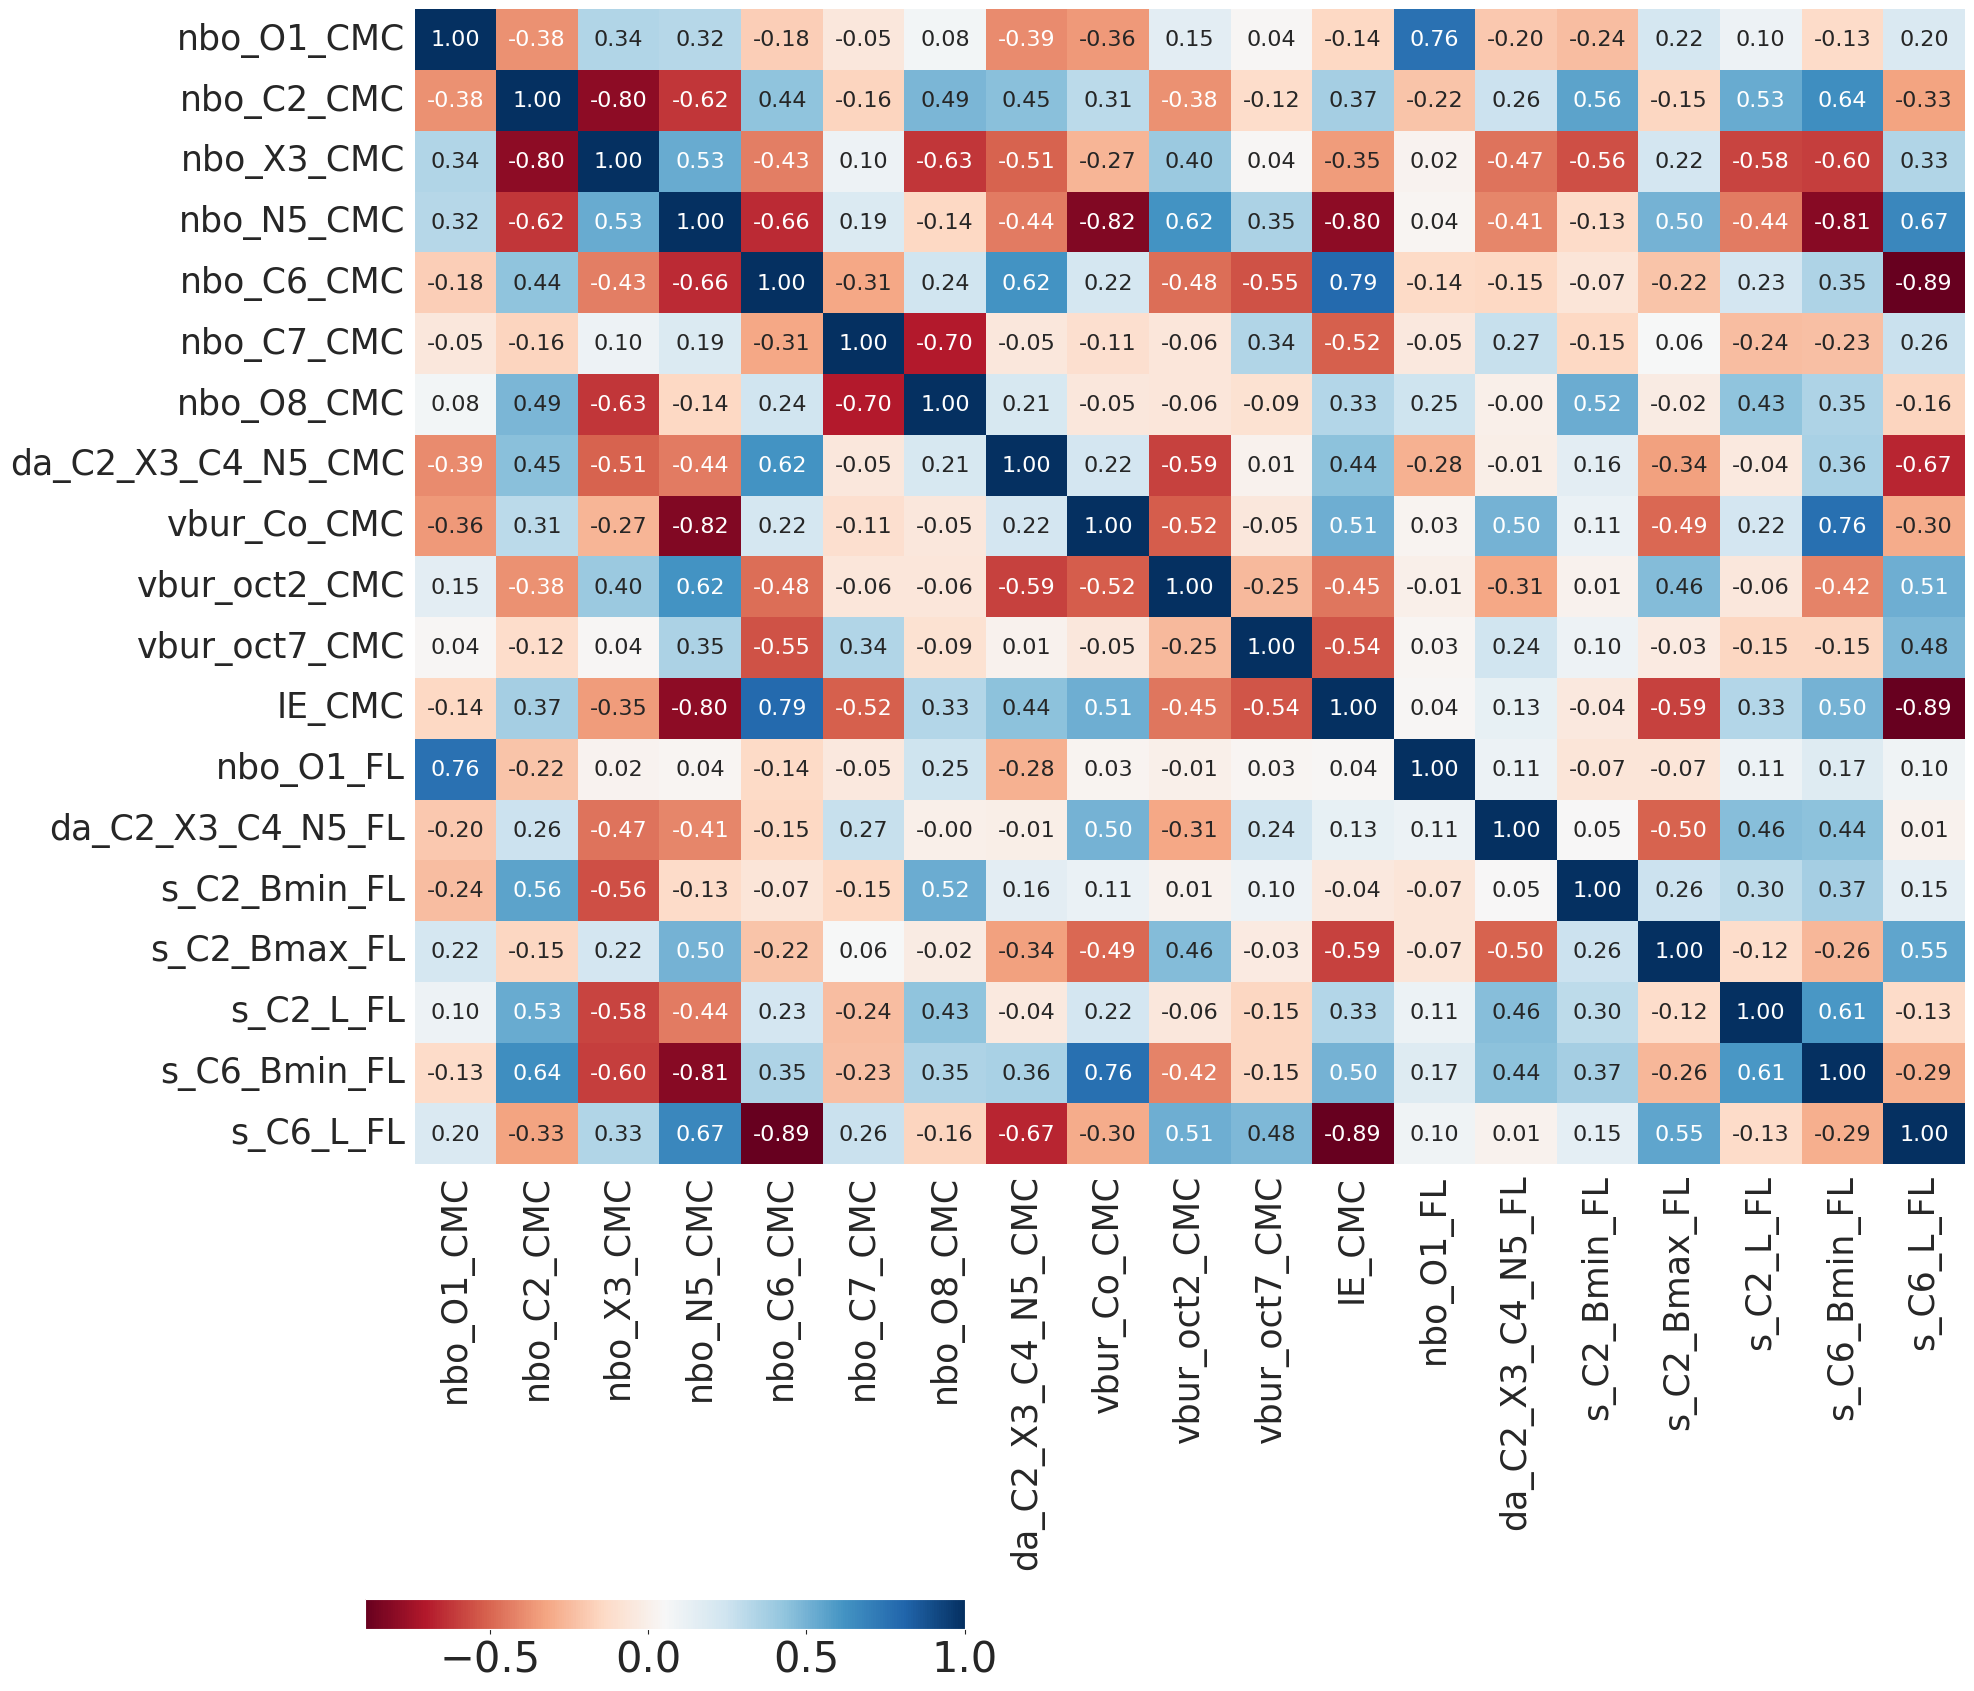

In [ ]:
cor = df_features.corr()
fig, ax = plt.subplots(figsize=(20, 15))
axs = sns.heatmap(cor, xticklabels=True, yticklabels=True, annot=True,
                  fmt=".2f", cmap="RdBu", annot_kws={'size': 16}, cbar=False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

cbar_ax = fig.add_axes([0.1, -0.2, 0.3, 0.02])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=30)

In [ ]:
# Display the features with cor above the threshold
features_to_drop = list(set(X_train.columns.tolist()) - set(df_features.columns.tolist()))
features_to_drop

['s_C6_Bmax_FL',
 'nbo_X3_FL',
 'nbo_Co_CMC',
 'vbur_oct6_CMC',
 'ba_OCoN_CMC',
 'vbur_oct3_CMC',
 'bl_OCo_CMC',
 'nbo_O8_FL',
 'vbur_oct5_CMC',
 'nbo_C7_FL',
 'nbo_C4_FL',
 'nbo_N5_FL',
 'nbo_C4_CMC',
 'bl_NCo_CMC',
 'nbo_C2_FL',
 'nbo_C6_FL',
 'vbur_oct4_CMC']

In [ ]:
# Copying df_features dataframe
X_train_2 = df_features.copy(deep=True)
X_train_2.shape

(17, 19)

In [ ]:
# Dropping the eliminated features from the test sample as well
X_test_2 = X_test.drop(columns = features_to_drop)

In [ ]:
loo = LeaveOneOut()

#Parameter class screening#

##Model screening for M1##

Parameter class: M1
Model 1:
Train MAE: 0.3675599221334234, Train RMSE: 0.4495676975668651, Train R2: 0.39639547880006254
Test MAE: 0.3252888082870809, Test RMSE: 0.4573269526145554, Test R2: 0.45726267907607
Train LOO MAE: 0.41024879655984964
Features_indices: (18,), Features_names: s_C6_L_FL
Coefficients: [0.36408471]
Intercept: -0.8466005620730008

Parameter class: M1
Model 2:
Train MAE: 0.3809640044050975, Train RMSE: 0.4478719013090115, Train R2: 0.40094055520076344
Test MAE: 0.27705092063570796, Test RMSE: 0.41002181307070873, Test R2: 0.5637353587977703
Train LOO MAE: 0.4281679290189616
Features_indices: (11,), Features_names: IE_CMC
Coefficients: [-0.36699097]
Intercept: -0.8559889817933832

Parameter class: M1
Model 3:
Train MAE: 0.40268126213069466, Train RMSE: 0.4816897802849804, Train R2: 0.30705757542768297
Test MAE: 0.5790751979243296, Test RMSE: 0.6722626186283113, Test R2: -0.1727731583720986
Train LOO MAE: 0.45992204467713976
Features_indices: (14,), Features_names: s_

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

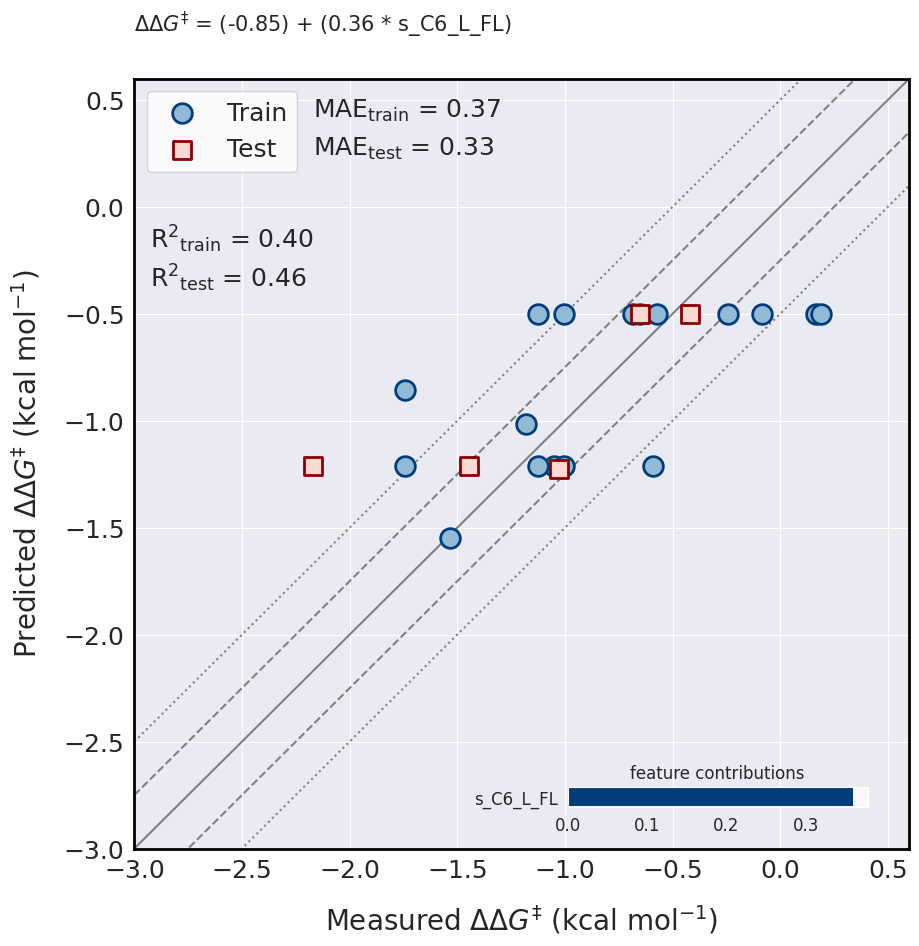

In [ ]:
top5_models_M1 = top5_model_selector(1) # top5_model_selector(param_class_num=1)

# Value retrieving
first_model_M1 = top5_models_M1[0][7]  # The model is the 8th item in the tuple
feature_indices_M1 = top5_models_M1[0][8]  # The feature indices are the 9th item in the tuple
model_subset_names_M1 = top5_models_M1[0][9] # The feature names are the 10th item in the tuple
param_class_M1 = top5_models_M1[0][10] # The feature names are the 11th item in the tuple

# Plotting for the best M1 model
plot_actual_vs_predicted(first_model_M1, feature_indices_M1, model_subset_names_M1, 1)

##Model screening for M2##

Parameter class: M2
Model 1:
Train MAE: 0.19504401332462937, Train RMSE: 0.280097452916395, Train R2: 0.7656955127994555
Test MAE: 0.32201920110059046, Test RMSE: 0.3694590373561754, Test R2: 0.6457835872387994
Train LOO MAE: 0.22674600998376523
Features_indices: (1, 11), Features_names: nbo_C2_CMC, IE_CMC
Coefficients: [ 0.37532809 -0.50698903]
Intercept: -0.8226188322384587

Parameter class: M2
Model 2:
Train MAE: 0.23236491110840113, Train RMSE: 0.31013296173897953, Train R2: 0.71275125489268
Test MAE: 0.3664282980021625, Test RMSE: 0.4259385972733255, Test R2: 0.5292069050213183
Train LOO MAE: 0.28109947266370844
Features_indices: (1, 18), Features_names: nbo_C2_CMC, s_C6_L_FL
Coefficients: [0.34343124 0.4766454 ]
Intercept: -0.8118142753176899

Parameter class: M2
Model 3:
Train MAE: 0.24944900515626667, Train RMSE: 0.3425672569880609, Train R2: 0.6495274671646228
Test MAE: 0.3060355645550773, Test RMSE: 0.3685493864157965, Test R2: 0.647525683640316
Train LOO MAE: 0.2905320569682

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

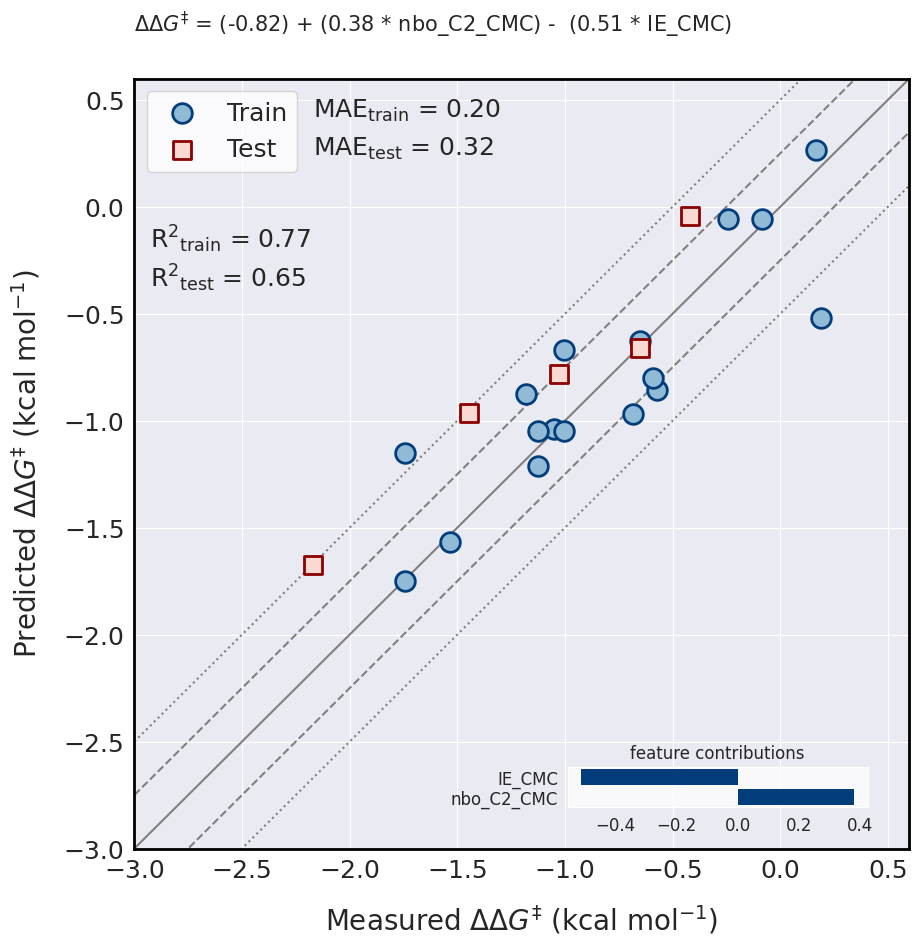

In [ ]:
top5_models_M2 = top5_model_selector(2) # top5_model_selector(param_class_num=2)


first_model_M2 = top5_models_M2[0][7]
feature_indices_M2 = top5_models_M2[0][8]
model_subset_names_M2 = top5_models_M2[0][9]
param_class_M2 = top5_models_M2[0][10]

# Plotting for the best M2 model
plot_actual_vs_predicted(first_model_M2, feature_indices_M2, model_subset_names_M2, 2)

##Model screening for M3##

Parameter class: M3
Model 1:
Train MAE: 0.18037864338000245, Train RMSE: 0.2680550850344698, Train R2: 0.7854095515716458
Test MAE: 0.3265354274356852, Test RMSE: 0.36960146153366713, Test R2: 0.645510438120629
Train LOO MAE: 0.2178701801180705
Features_indices: (1, 4, 11), Features_names: nbo_C2_CMC, nbo_C6_CMC, IE_CMC
Coefficients: [ 0.39796711 -0.13408632 -0.40868117]
Intercept: -0.8208808368100713

Parameter class: M3
Model 2:
Train MAE: 0.18510696164753493, Train RMSE: 0.25759405658487733, Train R2: 0.8018318004497064
Test MAE: 0.253893009520654, Test RMSE: 0.3048592139912579, Test R2: 0.7588236362140321
Train LOO MAE: 0.22685879014684524
Features_indices: (1, 11, 16), Features_names: nbo_C2_CMC, IE_CMC, s_C2_L_FL
Coefficients: [ 0.31386558 -0.52721336  0.12559828]
Intercept: -0.83948675692915

Parameter class: M3
Model 3:
Train MAE: 0.18569222848132574, Train RMSE: 0.2692110762165658, Train R2: 0.7835547122409293
Test MAE: 0.3303039942662226, Test RMSE: 0.3763625230363793, Test R

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

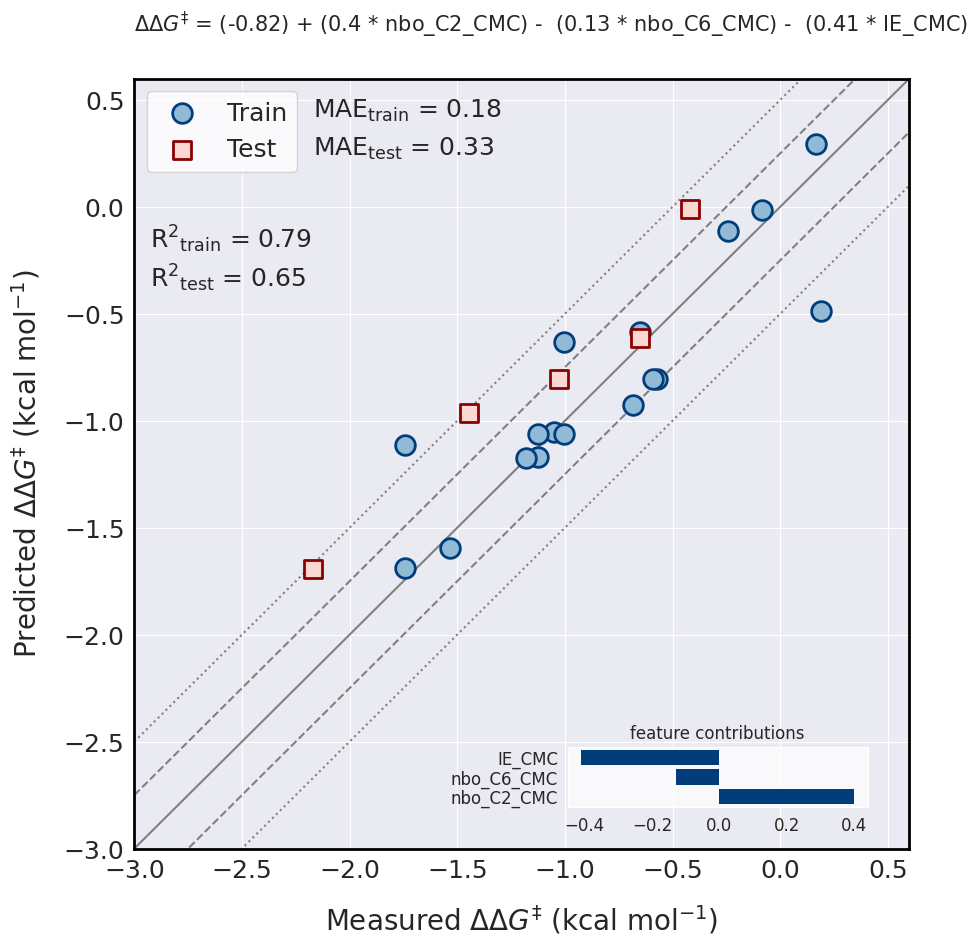

In [ ]:
top5_models_M3 = top5_model_selector(3) # top5_model_selector(param_class_num=3)


first_model_M3 = top5_models_M3[0][7]
feature_indices_M3 = top5_models_M3[0][8]
model_subset_names_M3 = top5_models_M3[0][9]
param_class_M3 = top5_models_M3[0][10]

# Plotting for the best M3 model
plot_actual_vs_predicted(first_model_M3, feature_indices_M3, model_subset_names_M3, 3)

##Model screening for M4##

Parameter class: M4
Model 1:
Train MAE: 0.1599497227937772, Train RMSE: 0.25017983144146233, Train R2: 0.8130752200954524
Test MAE: 0.2586125095471644, Test RMSE: 0.3129045190222945, Test R2: 0.7459262704869888
Train LOO MAE: 0.20122421270587834
Features_indices: (1, 4, 11, 16), Features_names: nbo_C2_CMC, nbo_C6_CMC, IE_CMC, s_C2_L_FL
Coefficients: [ 0.33795785 -0.10316293 -0.44938136  0.11195933]
Intercept: -0.8363178636029169

Parameter class: M4
Model 2:
Train MAE: 0.1606380076769717, Train RMSE: 0.23747780933319418, Train R2: 0.831574302389545
Test MAE: 0.3393160761202854, Test RMSE: 0.3863909514630428, Test R2: 0.612572907885092
Train LOO MAE: 0.33821997679809335
Features_indices: (1, 5, 8, 18), Features_names: nbo_C2_CMC, nbo_C7_CMC, vbur_Co_CMC, s_C6_L_FL
Coefficients: [ 0.39632138  0.08265379 -0.18174335  0.41290106]
Intercept: -0.8179761439272044

Parameter class: M4
Model 3:
Train MAE: 0.16280781977322475, Train RMSE: 0.2292919438569299, Train R2: 0.8429854571657815
Test MAE

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

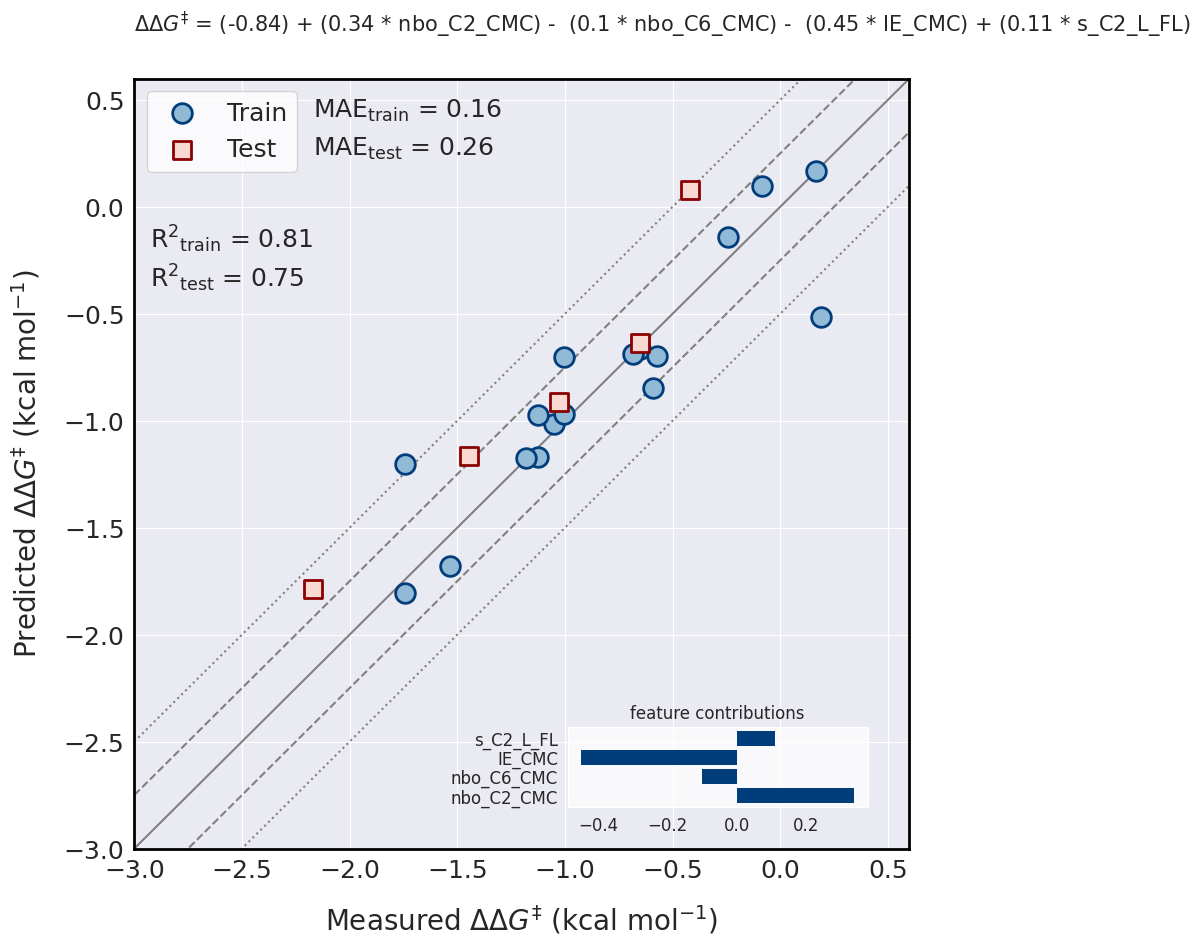

In [ ]:
top5_models_M4 = top5_model_selector(4) # top5_model_selector(param_class_num=4)


first_model_M4 = top5_models_M4[0][7]
feature_indices_M4 = top5_models_M4[0][8]
model_subset_names_M4 = top5_models_M4[0][9]
param_class_M4 = top5_models_M4[0][10]

# Plotting for the best M4 model
plot_actual_vs_predicted(first_model_M4, feature_indices_M4, model_subset_names_M4, 4)

##Model screening for M5##

Parameter class: M5
Model 1:
Train MAE: 0.1302143918709686, Train RMSE: 0.2159171787785405, Train R2: 0.8607687632721299
Test MAE: 0.25502913927211224, Test RMSE: 0.32626422100969155, Test R2: 0.7237673607159376
Train LOO MAE: 0.5056110860807536
Features_indices: (1, 3, 5, 16, 18), Features_names: nbo_C2_CMC, nbo_N5_CMC, nbo_C7_CMC, s_C2_L_FL, s_C6_L_FL
Coefficients: [0.45579213 0.3545694  0.10556916 0.09212817 0.26679189]
Intercept: -0.8398033988916542

Parameter class: M5
Model 2:
Train MAE: 0.14159508576216015, Train RMSE: 0.22899132658370297, Train R2: 0.8433969006808906
Test MAE: 0.26997725916037685, Test RMSE: 0.32421635417204797, Test R2: 0.7272241438728809
Train LOO MAE: 0.2138445961192387
Features_indices: (1, 4, 8, 11, 16), Features_names: nbo_C2_CMC, nbo_C6_CMC, vbur_Co_CMC, IE_CMC, s_C2_L_FL
Coefficients: [ 0.37323565 -0.17833175 -0.12397952 -0.33225919  0.10196902]
Intercept: -0.8337349659635485

Parameter class: M5
Model 3:
Train MAE: 0.14726255989008585, Train RMSE: 0.23

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

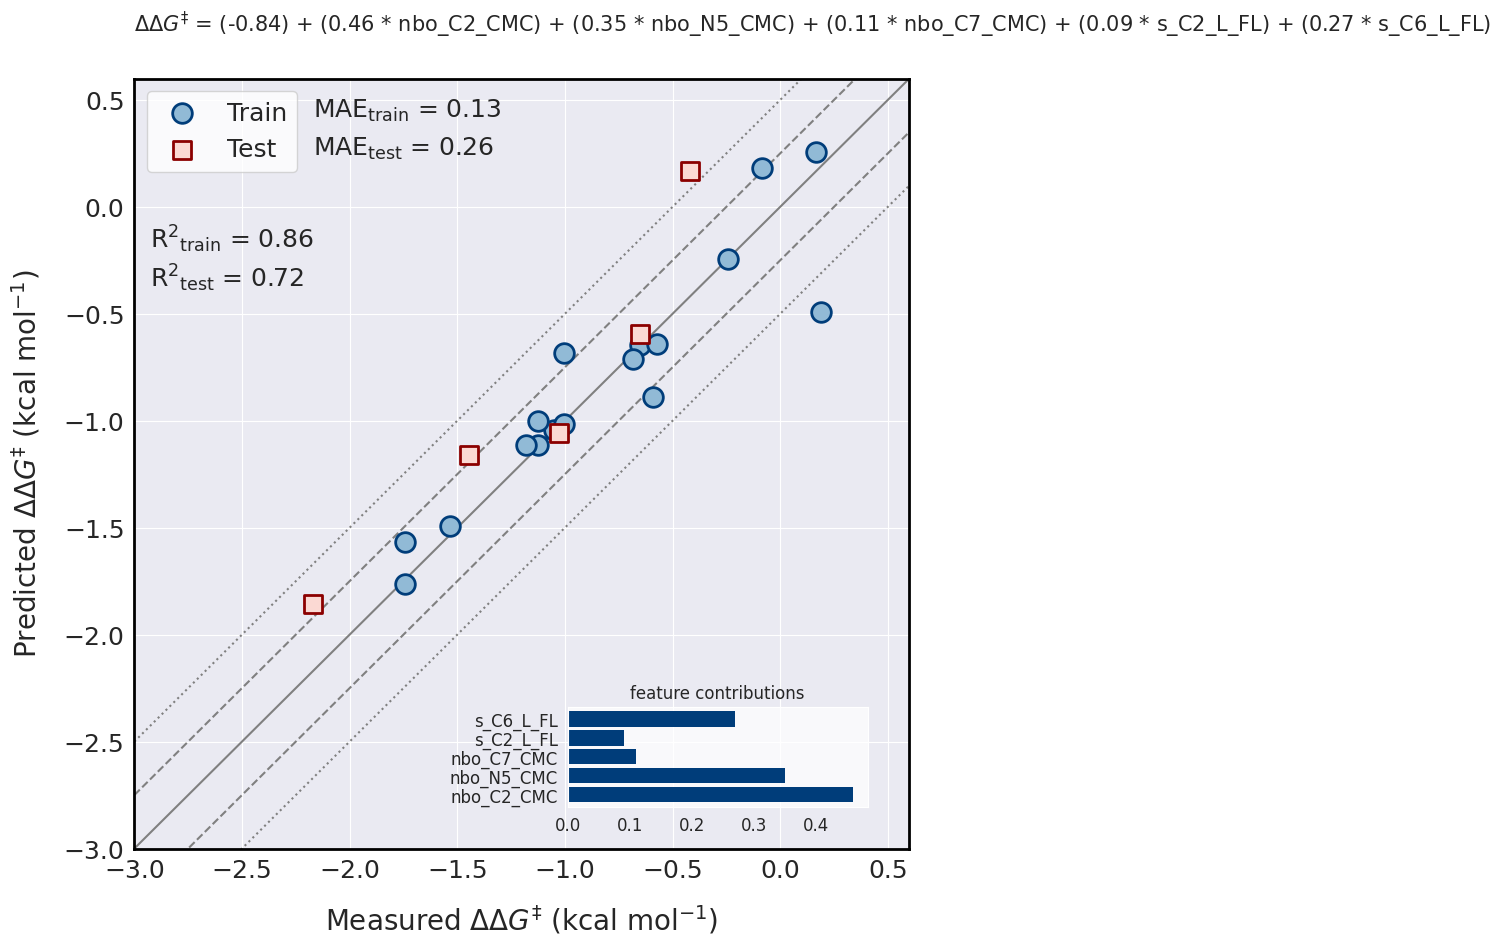

In [ ]:
top5_models_M5 = top5_model_selector(5) # top5_model_selector(param_class_num=5)


first_model_M5 = top5_models_M5[0][7]
feature_indices_M5 = top5_models_M5[0][8]
model_subset_names_M5 = top5_models_M5[0][9]
param_class_M5 = top5_models_M5[0][10]

# Plotting for the best M5 model
plot_actual_vs_predicted(first_model_M5, feature_indices_M5, model_subset_names_M5, 5)

##Model screening for M6##

Parameter class: M6
Model 1:
Train MAE: 0.11894759006185861, Train RMSE: 0.16432665965481644, Train R2: 0.9193548338026954
Test MAE: 0.4353304513637536, Test RMSE: 0.5360845801124687, Test R2: 0.2542337544477107
Train LOO MAE: 0.7750586822035629
Features_indices: (1, 3, 5, 7, 12, 17), Features_names: nbo_C2_CMC, nbo_N5_CMC, nbo_C7_CMC, da_C2_X3_C4_N5_CMC, nbo_O1_FL, s_C6_Bmin_FL
Coefficients: [ 0.44905037  0.72522473  0.14701019 -0.25227728 -0.18702678  0.40663757]
Intercept: -0.8337316809820199

Parameter class: M6
Model 2:
Train MAE: 0.120569076726136, Train RMSE: 0.17254214670321413, Train R2: 0.9110895760842059
Test MAE: 4.930215606014884, Test RMSE: 10.487508826899544, Test R2: -284.4176135771847
Train LOO MAE: 1.5581719600630148
Features_indices: (4, 5, 6, 12, 13, 16), Features_names: nbo_C6_CMC, nbo_C7_CMC, nbo_O8_CMC, nbo_O1_FL, da_C2_X3_C4_N5_FL, s_C2_L_FL
Coefficients: [-0.38507196  0.44431877  0.47183414 -0.2816608  -4.86579417  0.28080068]
Intercept: -1.9130088064157884

Pa

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

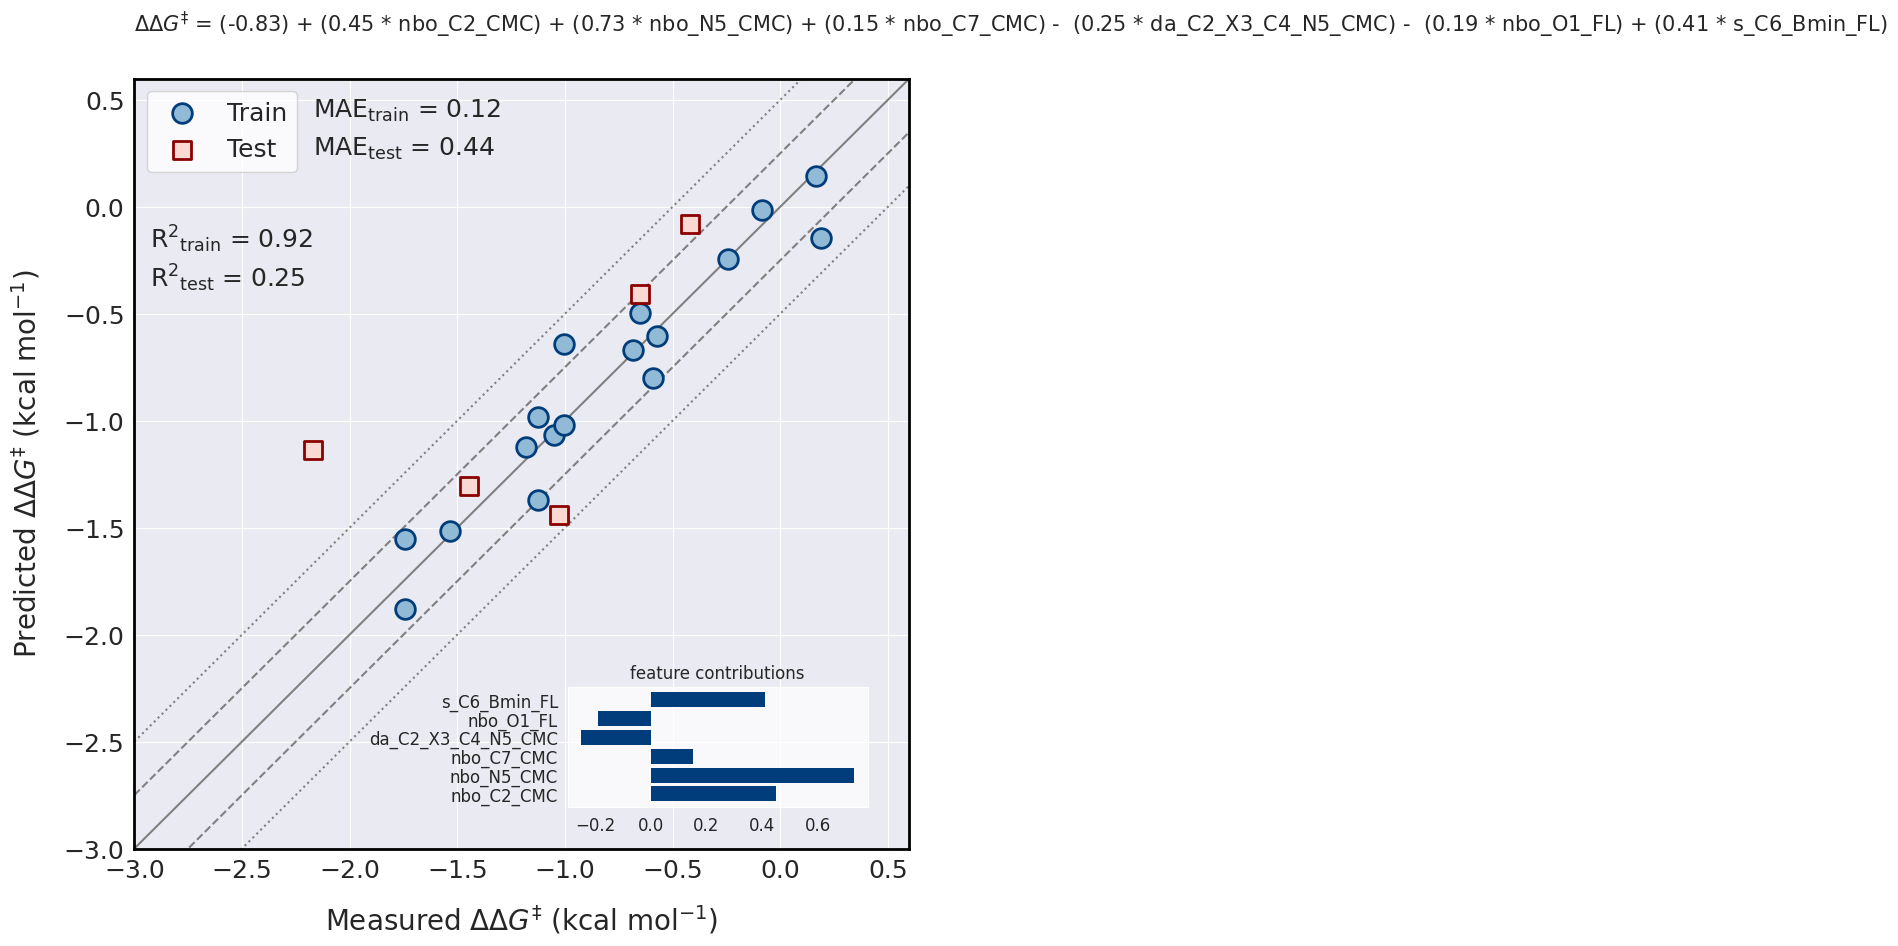

In [ ]:
top5_models_M6 = top5_model_selector(6) # top5_model_selector(param_class_num=6)


first_model_M6 = top5_models_M6[0][7]
feature_indices_M6 = top5_models_M6[0][8]
model_subset_names_M6 = top5_models_M6[0][9]
param_class_M6 = top5_models_M6[0][10]

# Plotting for the best M6 model
plot_actual_vs_predicted(first_model_M6, feature_indices_M6, model_subset_names_M6, 6)

#Summary of performance metrics#

In [ ]:
# Combining all models_performance lists
all_models_performance = [
    top5_models_M1,
    top5_models_M2,
    top5_models_M3,
    top5_models_M4,
    top5_models_M5,
    top5_models_M6
]

data = {
    "mae_train": [],
    "rmse_train": [],
    "r2_train": [],
    "mae_test": [],
    "rmse_test": [],
    "r2_test": [],
    "r2_test": [],
    "mae_train_loo": [],
    "param_class": []
}

# Iteration over each list to extract the first models from each parameter class
for param_class_index, models_performance in enumerate(all_models_performance, start=1):
    param_class = f'M{param_class_index}'
    performance = models_performance[0]
    data["mae_train"].append(performance[0])
    data["rmse_train"].append(performance[1])
    data["r2_train"].append(performance[2])
    data["mae_test"].append(performance[3])
    data["rmse_test"].append(performance[4])
    data["r2_test"].append(performance[5])
    data["mae_train_loo"].append(performance[6])
    data["param_class"].append(param_class)

# Create a DataFrame
df_metric_summary_model_1 = pd.DataFrame(data)

In [ ]:
# Display the DataFrame
df_metric_summary_model_1

mae_train  rmse_train  r2_train  mae_test  rmse_test   r2_test  \
0   0.367560    0.449568  0.396395  0.325289   0.457327  0.457263   
1   0.195044    0.280097  0.765696  0.322019   0.369459  0.645784   
2   0.180379    0.268055  0.785410  0.326535   0.369601  0.645510   
3   0.159950    0.250180  0.813075  0.258613   0.312905  0.745926   
4   0.130214    0.215917  0.860769  0.255029   0.326264  0.723767   
5   0.118948    0.164327  0.919355  0.435330   0.536085  0.254234   

   mae_train_loo param_class  
0       0.410249          M1  
1       0.226746          M2  
2       0.217870          M3  
3       0.201224          M4  
4       0.505611          M5  
5       0.775059          M6

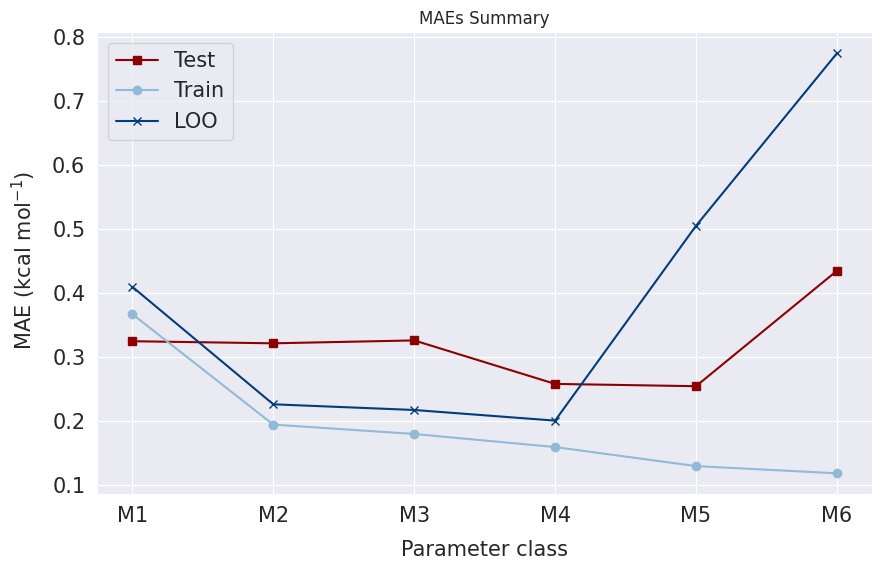

In [ ]:
# MAE summary

# Plot setting
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.set_style('darkgrid')

# Plotting each MAE metric
plt.plot(df_metric_summary_model_1['param_class'], df_metric_summary_model_1['mae_test'], '-s', label='Test', color='#8B0000')
plt.plot(df_metric_summary_model_1['param_class'], df_metric_summary_model_1['mae_train'], '-o', label='Train', color='#91BAD6')
plt.plot(df_metric_summary_model_1['param_class'], df_metric_summary_model_1['mae_train_loo'], '-x', label='LOO', color='#003d7a')

# Titles and labels setting
plt.title('MAEs Summary')
plt.xlabel('Parameter class', fontsize=15, labelpad=10)
plt.ylabel(r' MAE (kcal mol$^{-1}$)', fontsize=15, labelpad=10)
plt.legend(fontsize=15, loc = 'upper left')
plt.tick_params(axis ='both', which ='major', labelsize = 15, pad = 5)

# Show the plot
plt.show()

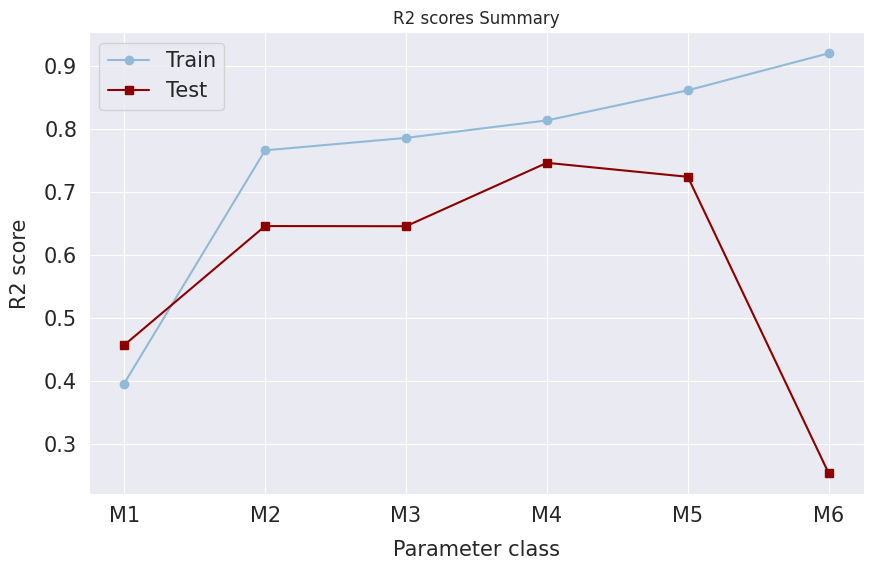

In [ ]:
# R2 score summary

# Plot setting
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.set_style('darkgrid')

# Plotting each MAE metric
plt.plot(df_metric_summary_model_1['param_class'], df_metric_summary_model_1['r2_train'], '-o', label='Train', color='#91BAD6')
plt.plot(df_metric_summary_model_1['param_class'], df_metric_summary_model_1['r2_test'], '-s', label='Test', color='#8B0000')

# Titles and labels setting
plt.title('R2 scores Summary')
plt.xlabel('Parameter class', fontsize=15, labelpad=10)
plt.ylabel(r'R2 score', fontsize=15, labelpad=10)
plt.legend(fontsize=15, loc = 'upper left')
plt.tick_params(axis ='both', which ='major', labelsize = 15, pad = 5)

# Show the plot
plt.show()

For best model in M4 parameter class:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

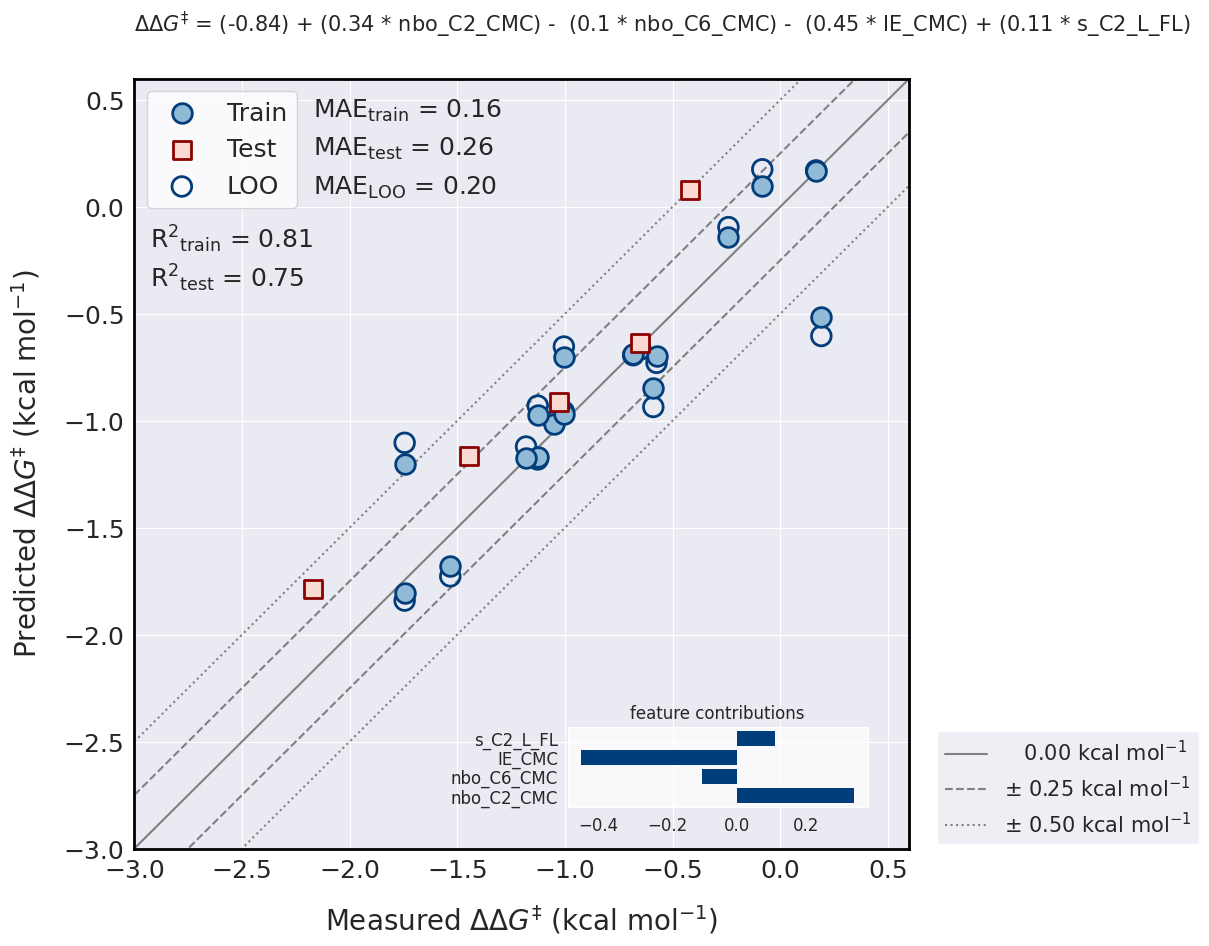

In [ ]:
# Final M4 plot for manuscript figure
y_train_loo_M4 = cross_val_predict(first_model_M4, X_train_2.iloc[:, list(feature_indices_M4)], y_train, cv=loo)

plot_actual_vs_predicted(first_model_M4, feature_indices_M4, model_subset_names_M4, 4, y_train_loo_M4, margin_ledgends=True)